In [1]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
import PIL

import torch.nn as nn
import torchvision

from utils.processing import *
from utils.vnfood_ds import *
from utils.trainer import *

In [1]:
import torch, sys
print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    x = torch.rand(20000, 20000, device='cuda')
    y = x @ x
    torch.cuda.synchronize()
    print("GPU matmul OK")


Python: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Torch: 2.5.1+cu121 | CUDA build: 12.1
CUDA available: True
GPU: Quadro RTX 5000
GPU matmul OK


In [2]:
# ==== Đường dẫn dữ liệu ====
# ROOT = "./vietnamese-foods/Images"   # <== đổi nếu cần
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== đổi nếu cần
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"


Name_food = {0: 'Banh beo',
 1:'Banh bot loc',
 2:'Banh can',
 3:'Banh canh',
 4:'Banh chung',
 5:'Banh cuon',
 6:'Banh duc',
 7:'Banh gio',
 8:'Banh khot',
 9:'Banh mi',
 10:'Banh pia',
 11:'Banh tet',
 12:'Banh trang nuong',
 13:'Banh xeo',
 14:'Bun bo Hue',
 15:'Bun dau mam tom',
 16:'Bun mam',
 17:'Bun rieu',
 18:'Bun thit nuong',
 19:'Ca kho to',
 20:'Canh chua',
 21:'Cao lau',
 22:'Chao long',
 23:'Com tam',
 24:'Goi cuon',
 25:'Hu tieu',
 26:'Mi quang',
 27:'Nem chua',
 28:'Pho',
 29:'Xoi xeo'}



In [3]:
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = getAllDataset()

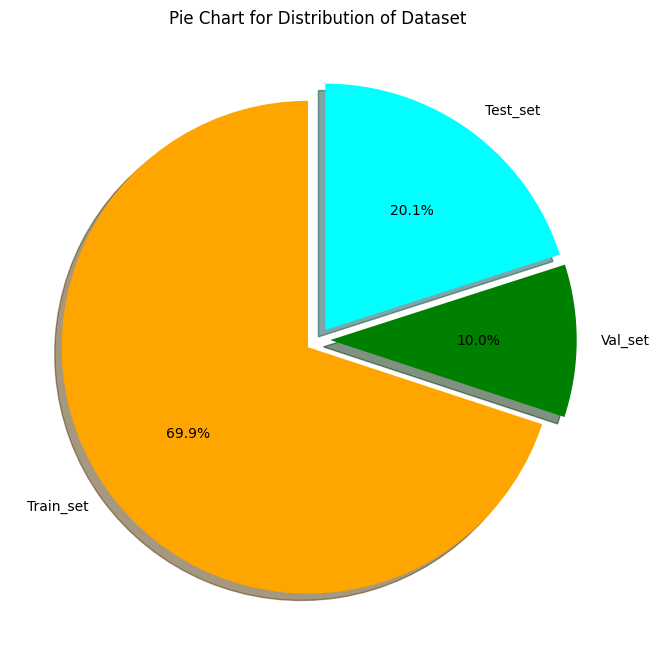

In [4]:
import matplotlib.pyplot as plt
data = {
    "Train_set" : len(train_paths),
    "Val_set": len(val_paths),
    "Test_set": len(test_paths)
}
colors = ['orange', 'green', 'cyan']
highlight =(0.05,0.05,0.05)
plt.subplots(figsize=(10, 8))
plt.pie(list(data.values()), explode=highlight, labels=data.keys(), colors=colors, autopct='%2.1f%%', shadow=True, startangle=90)
plt.title('Pie Chart for Distribution of Dataset')
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels)
val_labels = lb.fit_transform(val_labels)
test_labels = lb.fit_transform(test_labels)

In [6]:
train_labels = np.eye(30)[train_labels]
val_labels = np.eye(30)[val_labels]
test_labels = np.eye(30)[test_labels]
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} images)".format(pct, absolute)

In [7]:
import pandas as pd
def plot_compare_distributions(array1, array2, array3, food_name, title1='Train images distribution', title2='', title3 = '' ):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array3 = pd.DataFrame()
    df_array1['food_name'] = array1.argmax(axis=1)
    df_array2['food_name'] = array2.argmax(axis=1)
    df_array3['food_name'] = array3.argmax(axis=1)
    highlight =(0.05,0.05,0.05, 0.05)
    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)
    x = food_name.values()
    colors = ['orange', 'green', 'cyan', "red"]

    y = df_array1['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[1].set_title(title2)
    axs[1].grid()
    
    y = df_array3['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[2].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[2].set_title(title3)
    axs[2].grid()
    plt.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def _counts_from_logits(arr, n_classes: int):
    """arr: (N, C) logits/probs hoặc (N,) labels int.
       Trả về Series độ dài C, đủ mọi lớp (fill 0 nếu thiếu)."""
    if arr.ndim == 2:  # (N, C) -> lấy argmax
        labels = arr.argmax(axis=1)
    else:              # (N,) đã là label
        labels = arr
    s = pd.Series(labels).value_counts().sort_index()
    return s.reindex(range(n_classes), fill_value=0)

def _names_from_mapping(name_food: dict):
    """Trả về list tên lớp theo thứ tự id tăng dần."""
    return [name for name, idx in sorted(name_food.items(), key=lambda kv: kv[1])]

def _autopct(values):
    total = float(values.sum())
    def fmt(pct):
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return fmt

def plot_compare_distributions(array1, array2, array3, name_food: dict,
                               title1='Train images distribution',
                               title2='Val images distribution',
                               title3='Test images distribution'):
    n_classes = len(name_food)
    labels = _names_from_mapping(name_food)

    # Đếm từng split
    import numpy as np  # thêm trên đầu file

    y1 = _counts_from_logits(np.asarray(array1), n_classes)
    y2 = _counts_from_logits(np.asarray(array2), n_classes)
    y3 = _counts_from_logits(np.asarray(array3), n_classes)

    # explode & colors khớp số lớp
    explode = [0.05] * n_classes
    # Ghép nhiều bảng màu cho đủ 30+ màu
    palette = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
    colors = palette[:n_classes]

    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)

    axs[0].pie(y1.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y1.values), shadow=True)
    axs[0].set_title(title1); axs[0].grid()

    axs[1].pie(y2.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y2.values), shadow=True)
    axs[1].set_title(title2); axs[1].grid()

    axs[2].pie(y3.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y3.values), shadow=True)
    axs[2].set_title(title3); axs[2].grid()

    plt.tight_layout()
    plt.show()


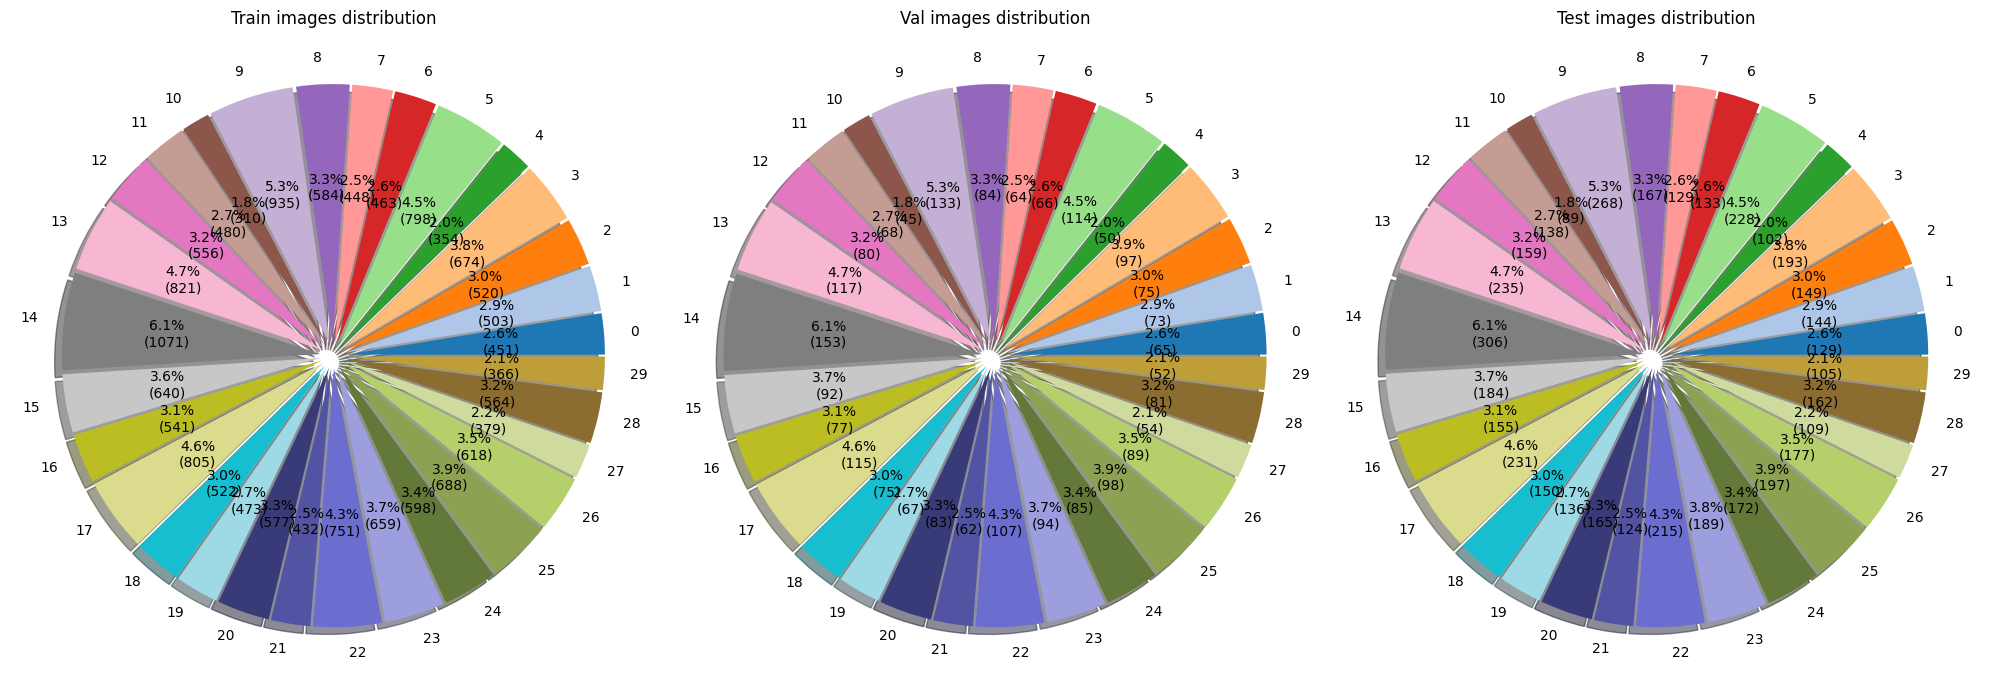

In [13]:
plot_compare_distributions(train_labels, val_labels, test_labels, Name_food, "Train images distribution", "Val images distribution", "Test images distribution")